This notebook executes the cross-reference between the WMT 19 DARR data used in the BARTScore paper and the DA human evaluation obtained in the WMT 19 Shared Metrics task. 

As of today (2022-09-10), the notebook proceeds as follows:

1. Load BARTScore pkl data files for each of the 7 languages. 
1. Flatten these results into (doc, ref, hyp).
1. Eliminate duplicates in the flattened version (since it is a pairwise comparison, it might happen so that there are duplicate entries).
1. Average over duplicate entries in the DA dataset (We have repeated (doc, ref, hyp) triplets which were assigned different scores. This can be explained by the lack of information about the systems that generated the hyp and the fact that different systems may end up producing the same hyp.)
1. Map DA (discrete [0, 100] to the [0, 1] domain)
1. Create train/dev/test set based on the context to avoid label leakage.
1. Create datasets w/ 2 classes and 5 classes. Using equally spaced thresholds in the range of [0, 1]. 



BARTScore syntax for WMT 19 - DARR dataset: 

```python
{
    "doc_id": {
        "src": "This is the source text.",
        "ref": "This is the reference translation.",
        "better": {
            "sys_name": "System name 1",
            "sys": "This is system translation 1.",
            "scores": {} 
        },
        "worse": {
            "sys_name": "System name 2",
            "sys": "This is system translation 2.",
            "scores": {}
        }
    }
}
```

In [1]:
import pandas as pd
import numpy as np

import joblib
import os

In [2]:
def print_sep(msg):
    print("\n" * 3)
    print("=" * 80)
    print(msg)
    print("=" * 80)

### BARTScore dataset preprocessing methods

In [3]:
def flatten(dataset: dict) -> list:
    flattened = []
    
    for doc_id, doc_data in dataset.items():
        for system in ("better", "worse"):
            sys_data = doc_data[system]
            data = {
                "src": doc_data["src"],
                "ref": doc_data["ref"],
                "mt": doc_data[system]["sys"],
                "sys_name": doc_data[system]["sys_name"],
                # To facilitate tracing back to the BARTScore paper
                "bartscore_doc_id": doc_id,
            }
            data.update({f"{col}": score for col, score in sys_data["scores"].items()})
            flattened.append(data)
    return flattened


def load_mt(data_dir, dataset_name) -> pd.DataFrame:
    filepath = f"{data_dir}/{dataset_name}/final_p.pkl"
    data = joblib.load(filepath)
    print(f"Loaded {len(data)} examples for {dataset_name}.")
    
    # Transform it into long format
    data = flatten(data)
    data = pd.DataFrame(data)
    
    # Remove duplicates
    duplicate_cols = ['src', 'ref', 'mt', 'sys_name']
    data = data[~data[duplicate_cols].duplicated()]
    print("Total length of data after removing duplicates:", len(data))

    return data

### Direct Assessment Methods

In [4]:
def load_mt_da(data_dir: str, dataset_name: str) -> pd.DataFrame:
    df_da = pd.read_csv(f"{data_dir}/2019-da.csv")
    df_da = df_da[df_da["lp"] == dataset_name]
    print("Total len of df_da:", len(df_da))

    # Average duplicate values for DA data
    duplicates_cols = ["lp", "src", "mt", "ref"]
    
    # Consider all duplicates (even first and last instances)
    duplicates_mask = df_da[duplicates_cols].duplicated(keep=False)
    duplicates = df_da[duplicates_mask].copy()
    duplicates_annotations = duplicates.groupby(duplicates_cols, as_index=False).count()["annotators"]

    duplicates = duplicates.groupby(duplicates_cols, as_index=False).mean()
    duplicates["annotators"] = duplicates_annotations

    df_da_non_dup = df_da[~duplicates_mask]
    df_da = pd.concat((df_da_non_dup, duplicates))
    print("Total length of df_da after removing duplicates:", len(df_da))
    
    return df_da

## Preprocess BARTScore datasets

Generate intermediate file with the preprocessing steps we mention before, including the duplicates handling and the scaling of the human scores. The files will be created at `"./experiments/mt_data/preprocessed/{LANGUAGE_PAIR}/data_darr_w_scores.csv"`

In [5]:
DIR_DATASET_RAW = "../datasets/mt_data/raw"
DIR_DATASET_PREPROC = "../datasets/mt_data/preproc"

PREPROC_DATA_FILENAME = "WMT19DARR_w_all_scores"

In [6]:
for src_lang in ("gu", "kk", "zh", "de", "fi", "lt", "ru"):
    language_pair = f"{src_lang}-en"
    output_dir = f"{DIR_DATASET_PREPROC}/{language_pair}"
    os.makedirs(output_dir, exist_ok=True)

    print_sep(language_pair)
    # -------------------------------------------------------------------------------
    # Step 1. Load and create long-format version of DARR dataset
    # -------------------------------------------------------------------------------
    df_darr = load_mt(DIR_DATASET_RAW, language_pair)
    # -------------------------------------------------------------------------------
    # Step 2. **Load DIRECT ASSESSMENT data**
    # -------------------------------------------------------------------------------
    df_da = load_mt_da(DIR_DATASET_RAW, language_pair)

    # -------------------------------------------------------------------------------
    # Step 3. Merge them based on src, ref, and mt :)
    # -------------------------------------------------------------------------------
    df_darr_w_scores = df_darr.merge(df_da, on=["src", "ref", "mt"], how="left")
    assert len(df_darr) == len(df_darr_w_scores)
    print("\nFinal length:", len(df_darr_w_scores))

    # -------------------------------------------------------------------------------
    # Step 4. Persist in intermediate file
    # -------------------------------------------------------------------------------
    out_filepath = f"{output_dir}/{PREPROC_DATA_FILENAME}.csv"
    df_darr_w_scores.to_csv(out_filepath, index=False)

    assert len(df_darr_w_scores) == len(pd.read_csv(out_filepath))





gu-en
Loaded 20110 examples for gu-en.
Total length of data after removing duplicates: 9117
Total len of df_da: 9063
Total length of df_da after removing duplicates: 9063

Final length: 9117




kk-en
Loaded 9728 examples for kk-en.
Total length of data after removing duplicates: 6422
Total len of df_da: 6789
Total length of df_da after removing duplicates: 6782

Final length: 6422




zh-en
Loaded 31070 examples for zh-en.
Total length of data after removing duplicates: 17278
Total len of df_da: 20170
Total length of df_da after removing duplicates: 18687

Final length: 17278




de-en
Loaded 85365 examples for de-en.
Total length of data after removing duplicates: 30150
Total len of df_da: 31887
Total length of df_da after removing duplicates: 25028

Final length: 30150




fi-en
Loaded 32179 examples for fi-en.
Total length of data after removing duplicates: 16577
Total len of df_da: 16021
Total length of df_da after removing duplicates: 16013

Final length: 16577




lt-en
Load

## TRAIN-DEV-TEST SPLIT



In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
def train_test_split_ids(ids, test_fraction, dev_fraction=None, seed=42):
    dev_ids, test_ids = [], []
    
    # Select the indices for the holdout set
    rand = np.random.default_rng(seed)
    ids = np.array(ids)
    rand.shuffle(ids)
    
    assert 0 < test_fraction <= 1, f"Invalid test_fraction: {test_fraction}"
    test_num = round(test_fraction * len(ids))
    
    test_ids = ids[:test_num]    
    print("Collecting", len(test_ids), "examples for the holdout set.")
          
    train_ids = ids[test_num:]
    if dev_fraction is not None:
        assert 0 < dev_fraction <= 1, f"Invalid dev_fraction: {dev_fraction}"
        dev_num = round(dev_fraction * len(ids))
    
        dev_ids = ids[test_num:test_num+dev_num]    
        print("Collecting", len(dev_ids), "examples for the dev set.")
    
        train_ids = ids[test_num+dev_num:]
    
    print("Collecting", len(train_ids), "examples for the training set.")
    return train_ids, dev_ids, test_ids


def assert_non_overlapping(list_ids):
    initial_set = {}

    for ss in list_ids:
        for s in ss:
            if initial_set.get(s, False):
                raise ValueError("Overlapping values")
            else:
                initial_set[s] = 1

In [9]:
from data_processing import *

In [10]:
DIR_DATASET_PREPROC = "../datasets/mt_data/preproc"
PREPROC_DATA_FILENAME = "WMT19DARR_w_all_scores"
TARGET_COL = "raw_score"

SEED = 71563
DEV_FRACTION = 0.30
TEST_FRACTION = 0.30

In [11]:
def collect_src(data: pd.DataFrame, unique_src, ids, col="src") -> pd.DataFrame:
    selected_src = unique_src[ids]
    data = data[data[col].isin(selected_src)].reset_index()
    
    return data

## Equal sized bins





gu-en
Len(train): 3644  |  Len(dev): 2736  |  Len(test): 2737
Train, dev, test set `human_score` distribution


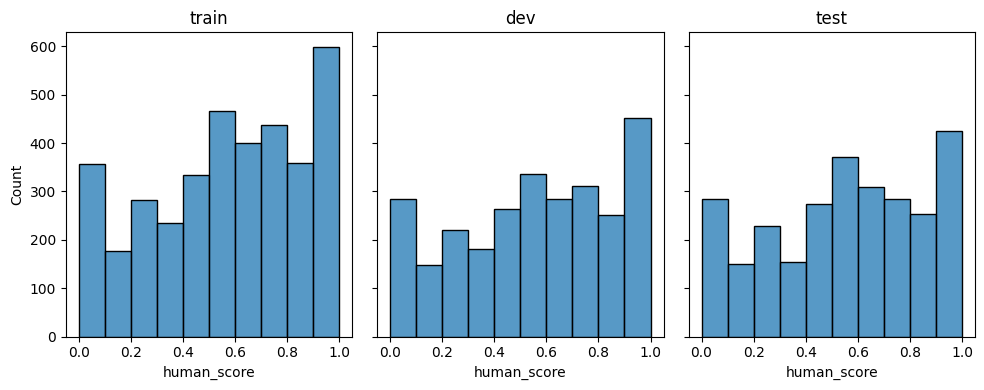

----------------------------------------------------------------------
2-class distribution using configs: {'binrange': (0, 1), 'bins': 2}
----------------------------------------------------------------------


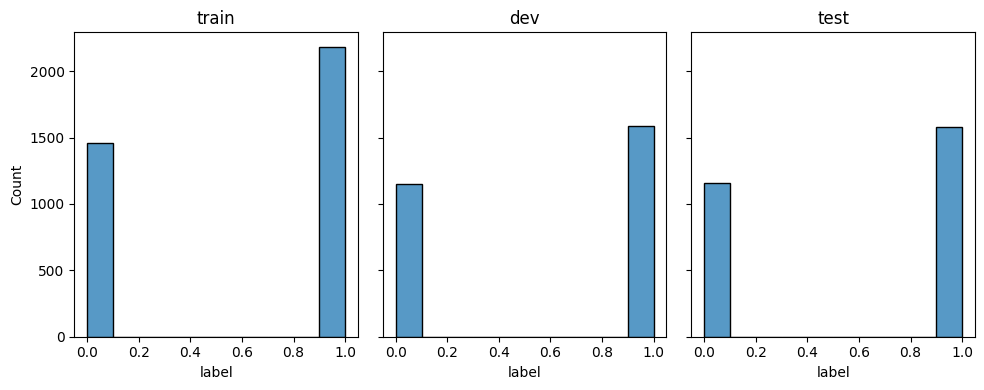

train
           index       bin
0  (-0.001, 0.5]  0.400933
1     (0.5, 1.0]  0.599067
dev
           index       bin
0  (-0.001, 0.5]  0.420322
1     (0.5, 1.0]  0.579678
test
           index       bin
0  (-0.001, 0.5]  0.422726
1     (0.5, 1.0]  0.577274
all
           index       bin
0  (-0.001, 0.5]  0.413294
1     (0.5, 1.0]  0.586706
--------------------------------------------------------------------------------
5-Class distribution using configs: {'binrange': (0, 1), 'bins': 5}
--------------------------------------------------------------------------------


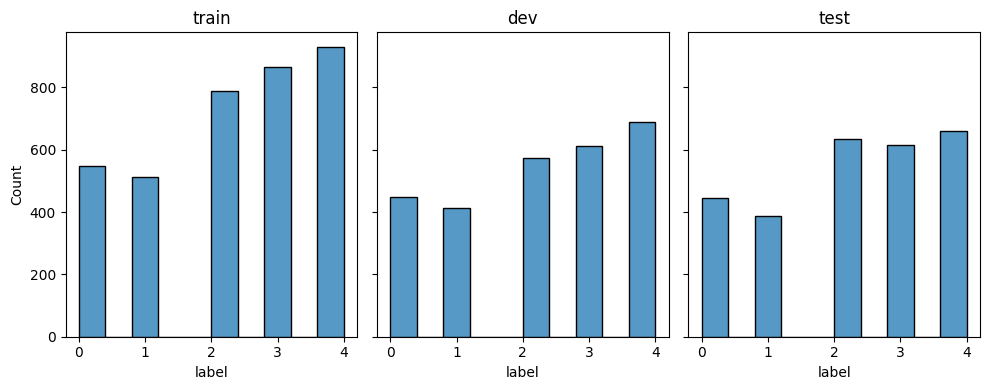

train
           index       bin
0  (-0.001, 0.2]  0.150110
1     (0.2, 0.4]  0.141054
2     (0.4, 0.6]  0.215971
3     (0.6, 0.8]  0.237651
4     (0.8, 1.0]  0.255214
dev
           index       bin
0  (-0.001, 0.2]  0.163743
1     (0.2, 0.4]  0.151316
2     (0.4, 0.6]  0.209430
3     (0.6, 0.8]  0.223684
4     (0.8, 1.0]  0.251827
test
           index       bin
0  (-0.001, 0.2]  0.162221
1     (0.2, 0.4]  0.141396
2     (0.4, 0.6]  0.231275
3     (0.6, 0.8]  0.224333
4     (0.8, 1.0]  0.240775
all
           index       bin
0  (-0.001, 0.2]  0.157837
1     (0.2, 0.4]  0.144236
2     (0.4, 0.6]  0.218603
3     (0.6, 0.8]  0.229461
4     (0.8, 1.0]  0.249863




kk-en
Len(train): 2554  |  Len(dev): 1928  |  Len(test): 1940
Train, dev, test set `human_score` distribution


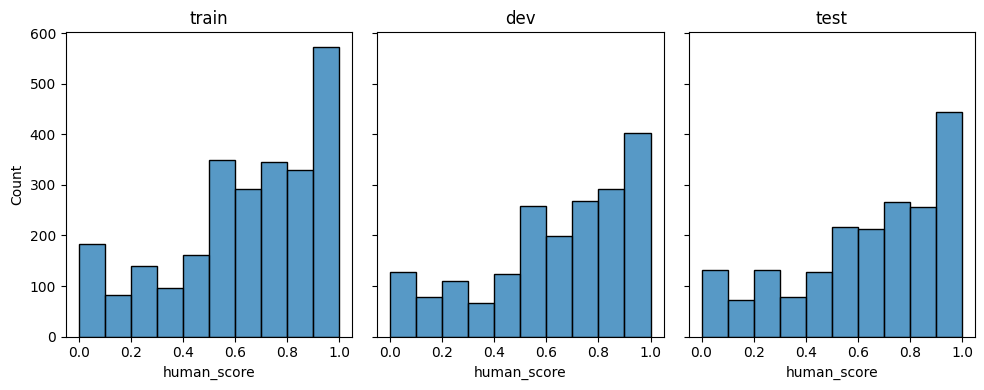

----------------------------------------------------------------------
2-class distribution using configs: {'binrange': (0, 1), 'bins': 2}
----------------------------------------------------------------------


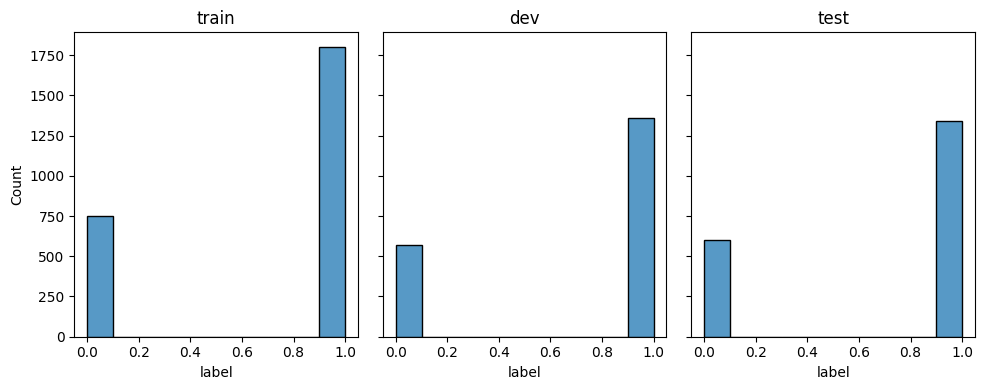

train
           index       bin
0  (-0.001, 0.5]  0.294832
1     (0.5, 1.0]  0.705168
dev
           index       bin
0  (-0.001, 0.5]  0.295643
1     (0.5, 1.0]  0.704357
test
           index       bin
0  (-0.001, 0.5]  0.309794
1     (0.5, 1.0]  0.690206
all
           index       bin
0  (-0.001, 0.5]  0.299595
1     (0.5, 1.0]  0.700405
--------------------------------------------------------------------------------
5-Class distribution using configs: {'binrange': (0, 1), 'bins': 5}
--------------------------------------------------------------------------------


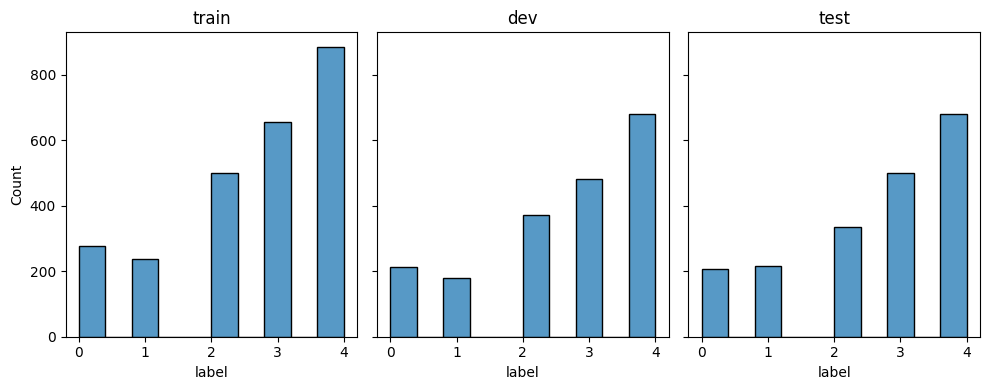

train
           index       bin
0  (-0.001, 0.2]  0.108849
1     (0.2, 0.4]  0.092796
2     (0.4, 0.6]  0.195380
3     (0.6, 0.8]  0.256460
4     (0.8, 1.0]  0.346515
dev
           index       bin
0  (-0.001, 0.2]  0.110996
1     (0.2, 0.4]  0.093361
2     (0.4, 0.6]  0.192946
3     (0.6, 0.8]  0.250000
4     (0.8, 1.0]  0.352697
test
           index       bin
0  (-0.001, 0.2]  0.107216
1     (0.2, 0.4]  0.111856
2     (0.4, 0.6]  0.172165
3     (0.6, 0.8]  0.257732
4     (0.8, 1.0]  0.351031
all
           index       bin
0  (-0.001, 0.2]  0.109000
1     (0.2, 0.4]  0.098723
2     (0.4, 0.6]  0.187636
3     (0.6, 0.8]  0.254905
4     (0.8, 1.0]  0.349735




zh-en
Len(train): 6972  |  Len(dev): 5184  |  Len(test): 5122
Train, dev, test set `human_score` distribution


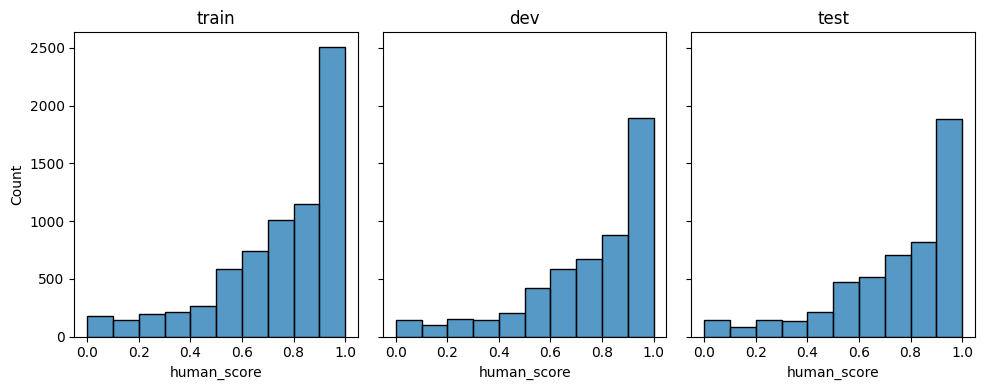

----------------------------------------------------------------------
2-class distribution using configs: {'binrange': (0, 1), 'bins': 2}
----------------------------------------------------------------------


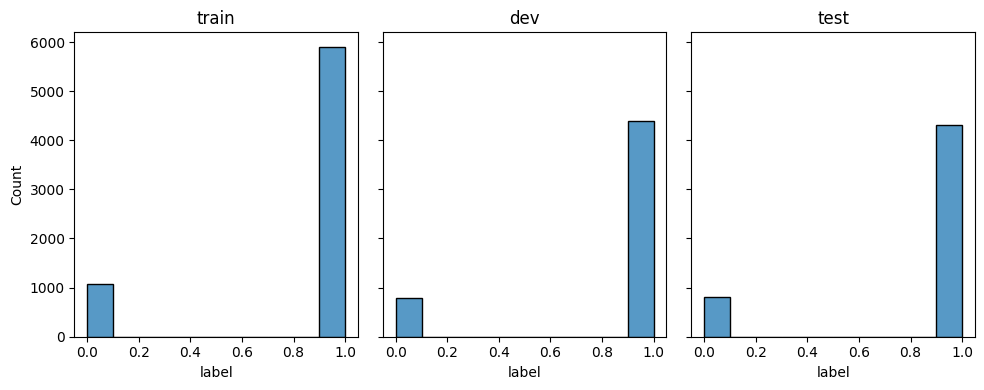

train
           index       bin
0  (-0.001, 0.5]  0.153471
1     (0.5, 1.0]  0.846529
dev
           index       bin
0  (-0.001, 0.5]  0.153742
1     (0.5, 1.0]  0.846258
test
           index       bin
0  (-0.001, 0.5]  0.158141
1     (0.5, 1.0]  0.841859
all
           index       bin
0  (-0.001, 0.5]  0.154937
1     (0.5, 1.0]  0.845063
--------------------------------------------------------------------------------
5-Class distribution using configs: {'binrange': (0, 1), 'bins': 5}
--------------------------------------------------------------------------------


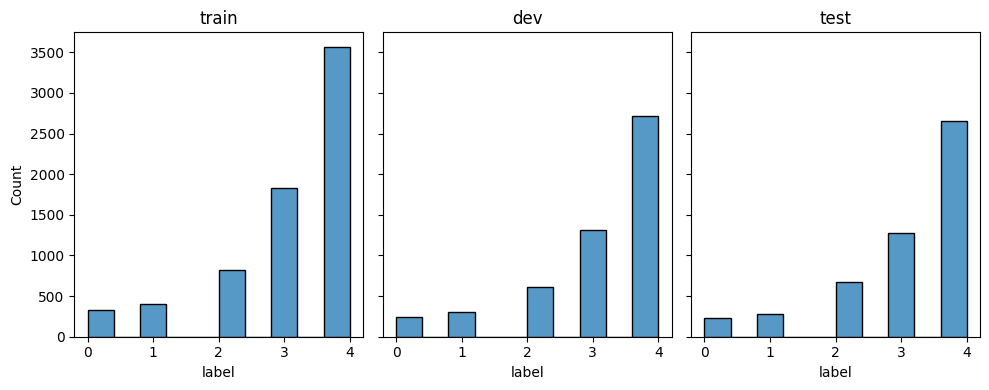

train
           index       bin
0  (-0.001, 0.2]  0.048049
1     (0.2, 0.4]  0.058520
2     (0.4, 0.6]  0.118330
3     (0.6, 0.8]  0.263339
4     (0.8, 1.0]  0.511761
dev
           index       bin
0  (-0.001, 0.2]  0.047261
1     (0.2, 0.4]  0.058449
2     (0.4, 0.6]  0.117477
3     (0.6, 0.8]  0.252315
4     (0.8, 1.0]  0.524498
test
           index       bin
0  (-0.001, 0.2]  0.046076
1     (0.2, 0.4]  0.054666
2     (0.4, 0.6]  0.131004
3     (0.6, 0.8]  0.249121
4     (0.8, 1.0]  0.519133
all
           index       bin
0  (-0.001, 0.2]  0.047228
1     (0.2, 0.4]  0.057356
2     (0.4, 0.6]  0.121831
3     (0.6, 0.8]  0.255817
4     (0.8, 1.0]  0.517768




de-en
Len(train): 12062  |  Len(dev): 9077  |  Len(test): 9011
Train, dev, test set `human_score` distribution


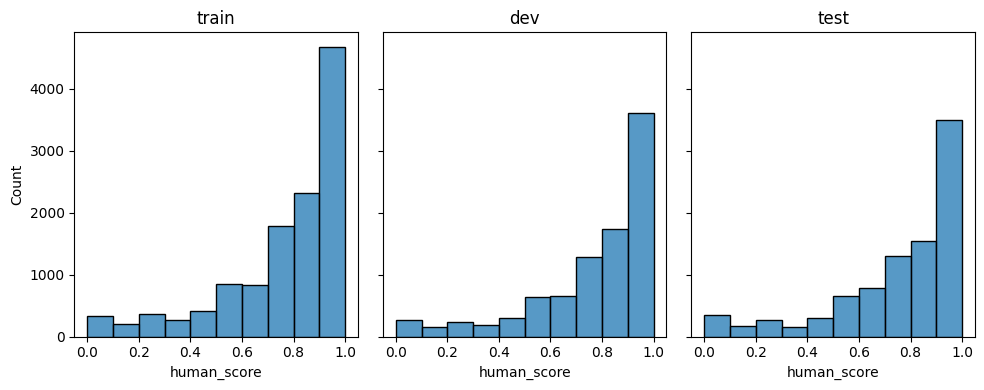

----------------------------------------------------------------------
2-class distribution using configs: {'binrange': (0, 1), 'bins': 2}
----------------------------------------------------------------------


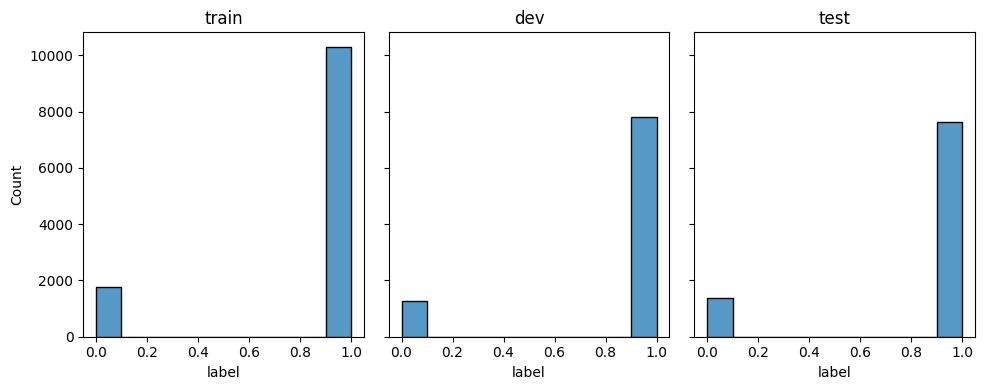

train
           index       bin
0  (-0.001, 0.5]  0.145747
1     (0.5, 1.0]  0.854253
dev
           index       bin
0  (-0.001, 0.5]  0.140134
1     (0.5, 1.0]  0.859866
test
           index       bin
0  (-0.001, 0.5]  0.152036
1     (0.5, 1.0]  0.847964
all
           index       bin
0  (-0.001, 0.5]  0.145937
1     (0.5, 1.0]  0.854063
--------------------------------------------------------------------------------
5-Class distribution using configs: {'binrange': (0, 1), 'bins': 5}
--------------------------------------------------------------------------------


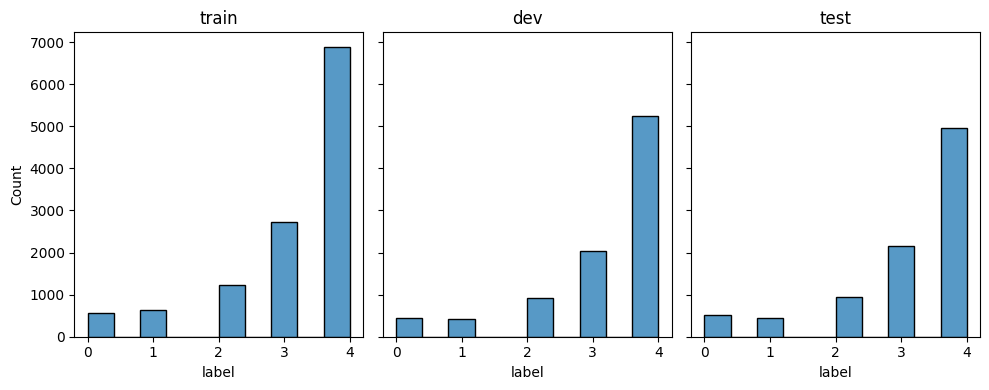

train
           index       bin
0  (-0.001, 0.2]  0.046427
1     (0.2, 0.4]  0.052810
2     (0.4, 0.6]  0.102802
3     (0.6, 0.8]  0.226911
4     (0.8, 1.0]  0.571050
dev
           index       bin
0  (-0.001, 0.2]  0.047703
1     (0.2, 0.4]  0.046161
2     (0.4, 0.6]  0.102567
3     (0.6, 0.8]  0.224854
4     (0.8, 1.0]  0.578715
test
           index       bin
0  (-0.001, 0.2]  0.057707
1     (0.2, 0.4]  0.048052
2     (0.4, 0.6]  0.104095
3     (0.6, 0.8]  0.239374
4     (0.8, 1.0]  0.550771
all
           index       bin
0  (-0.001, 0.2]  0.050182
1     (0.2, 0.4]  0.049386
2     (0.4, 0.6]  0.103118
3     (0.6, 0.8]  0.230017
4     (0.8, 1.0]  0.567297




fi-en
Len(train): 6638  |  Len(dev): 5013  |  Len(test): 4926
Train, dev, test set `human_score` distribution


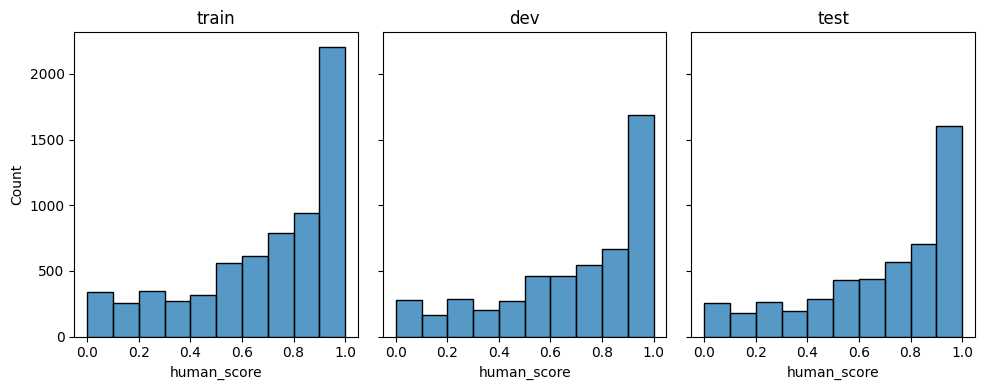

----------------------------------------------------------------------
2-class distribution using configs: {'binrange': (0, 1), 'bins': 2}
----------------------------------------------------------------------


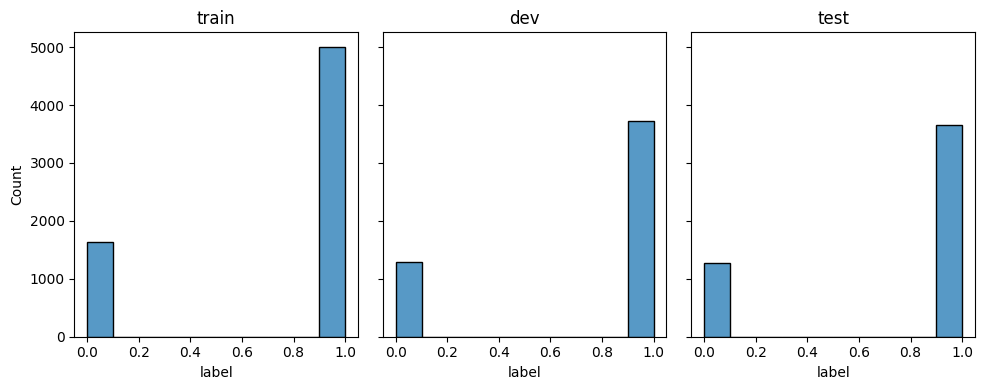

train
           index       bin
0  (-0.001, 0.5]  0.246008
1     (0.5, 1.0]  0.753992
dev
           index       bin
0  (-0.001, 0.5]  0.256932
1     (0.5, 1.0]  0.743068
test
           index       bin
0  (-0.001, 0.5]  0.259237
1     (0.5, 1.0]  0.740763
all
           index       bin
0  (-0.001, 0.5]  0.253242
1     (0.5, 1.0]  0.746758
--------------------------------------------------------------------------------
5-Class distribution using configs: {'binrange': (0, 1), 'bins': 5}
--------------------------------------------------------------------------------


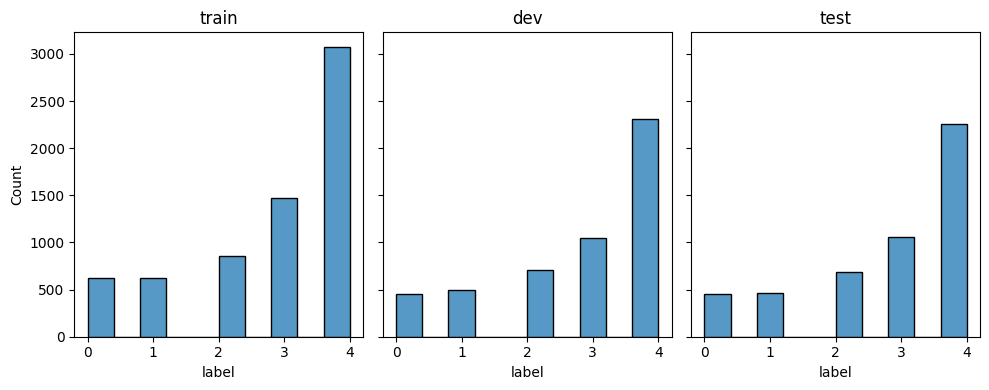

train
           index       bin
0  (-0.001, 0.2]  0.093552
1     (0.2, 0.4]  0.093100
2     (0.4, 0.6]  0.128201
3     (0.6, 0.8]  0.221904
4     (0.8, 1.0]  0.463242
dev
           index       bin
0  (-0.001, 0.2]  0.090565
1     (0.2, 0.4]  0.098544
2     (0.4, 0.6]  0.141831
3     (0.6, 0.8]  0.208657
4     (0.8, 1.0]  0.460403
test
           index       bin
0  (-0.001, 0.2]  0.092570
1     (0.2, 0.4]  0.094397
2     (0.4, 0.6]  0.140073
3     (0.6, 0.8]  0.215794
4     (0.8, 1.0]  0.457166
all
           index       bin
0  (-0.001, 0.2]  0.092357
1     (0.2, 0.4]  0.095132
2     (0.4, 0.6]  0.135851
3     (0.6, 0.8]  0.216083
4     (0.8, 1.0]  0.460578




lt-en
Len(train): 4153  |  Len(dev): 3085  |  Len(test): 3055
Train, dev, test set `human_score` distribution


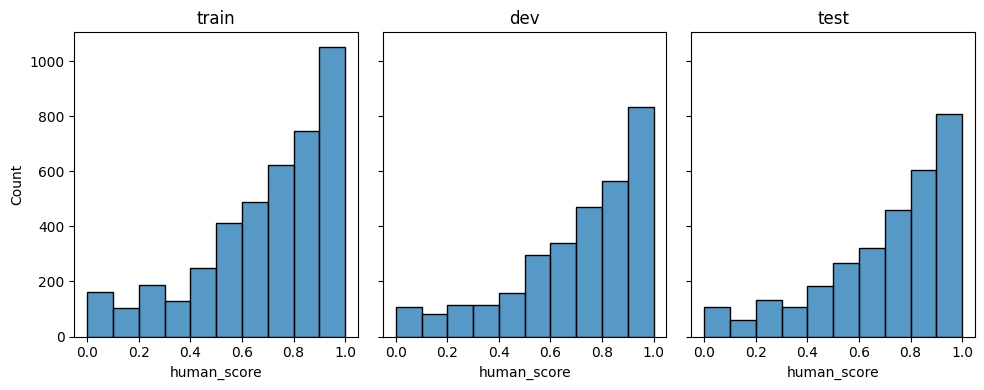

----------------------------------------------------------------------
2-class distribution using configs: {'binrange': (0, 1), 'bins': 2}
----------------------------------------------------------------------


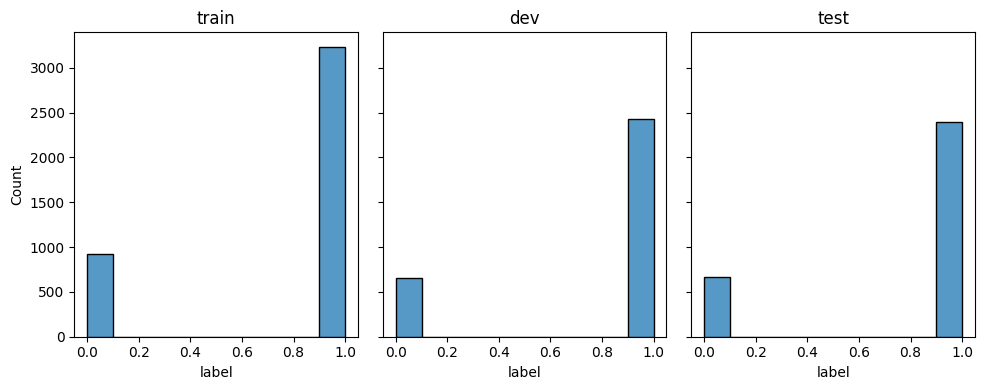

train
           index       bin
0  (-0.001, 0.5]  0.221045
1     (0.5, 1.0]  0.778955
dev
           index       bin
0  (-0.001, 0.5]  0.212642
1     (0.5, 1.0]  0.787358
test
           index       bin
0  (-0.001, 0.5]  0.216367
1     (0.5, 1.0]  0.783633
all
           index       bin
0  (-0.001, 0.5]  0.217138
1     (0.5, 1.0]  0.782862
--------------------------------------------------------------------------------
5-Class distribution using configs: {'binrange': (0, 1), 'bins': 5}
--------------------------------------------------------------------------------


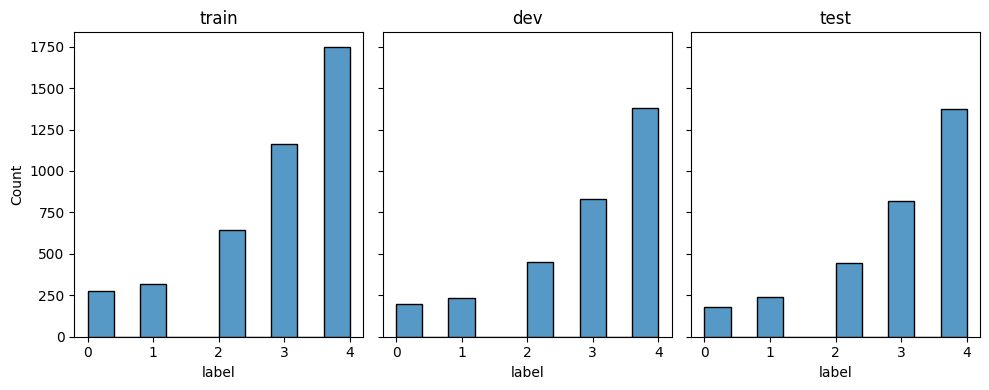

train
           index       bin
0  (-0.001, 0.2]  0.066940
1     (0.2, 0.4]  0.077053
2     (0.4, 0.6]  0.155069
3     (0.6, 0.8]  0.279798
4     (0.8, 1.0]  0.421141
dev
           index       bin
0  (-0.001, 0.2]  0.063857
1     (0.2, 0.4]  0.074878
2     (0.4, 0.6]  0.145219
3     (0.6, 0.8]  0.269368
4     (0.8, 1.0]  0.446677
test
           index       bin
0  (-0.001, 0.2]  0.058265
1     (0.2, 0.4]  0.078560
2     (0.4, 0.6]  0.145336
3     (0.6, 0.8]  0.268740
4     (0.8, 1.0]  0.449100
all
           index       bin
0  (-0.001, 0.2]  0.063441
1     (0.2, 0.4]  0.076848
2     (0.4, 0.6]  0.149228
3     (0.6, 0.8]  0.273390
4     (0.8, 1.0]  0.437093




ru-en
Len(train): 7721  |  Len(dev): 5813  |  Len(test): 5930
Train, dev, test set `human_score` distribution


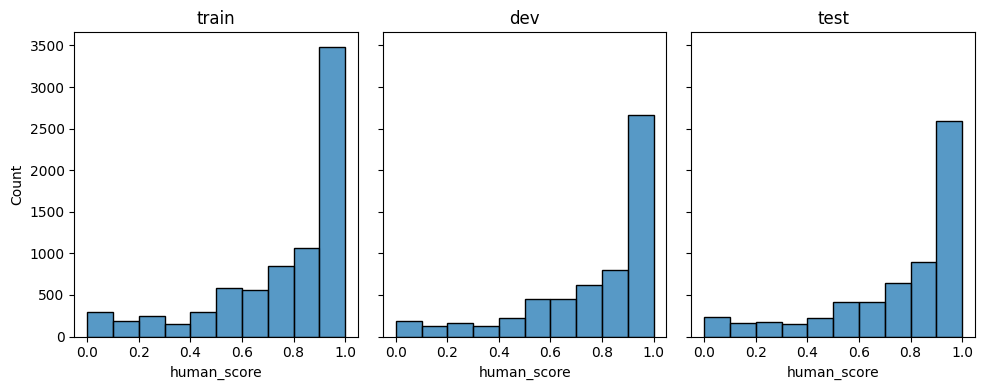

----------------------------------------------------------------------
2-class distribution using configs: {'binrange': (0, 1), 'bins': 2}
----------------------------------------------------------------------


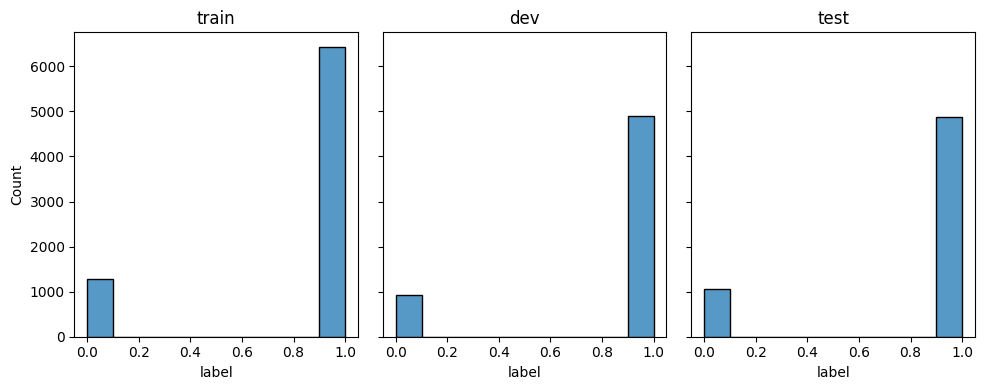

train
           index       bin
0  (-0.001, 0.5]  0.166947
1     (0.5, 1.0]  0.833053
dev
           index       bin
0  (-0.001, 0.5]  0.159126
1     (0.5, 1.0]  0.840874
test
           index       bin
0  (-0.001, 0.5]  0.179427
1     (0.5, 1.0]  0.820573
all
           index       bin
0  (-0.001, 0.5]  0.168413
1     (0.5, 1.0]  0.831587
--------------------------------------------------------------------------------
5-Class distribution using configs: {'binrange': (0, 1), 'bins': 5}
--------------------------------------------------------------------------------


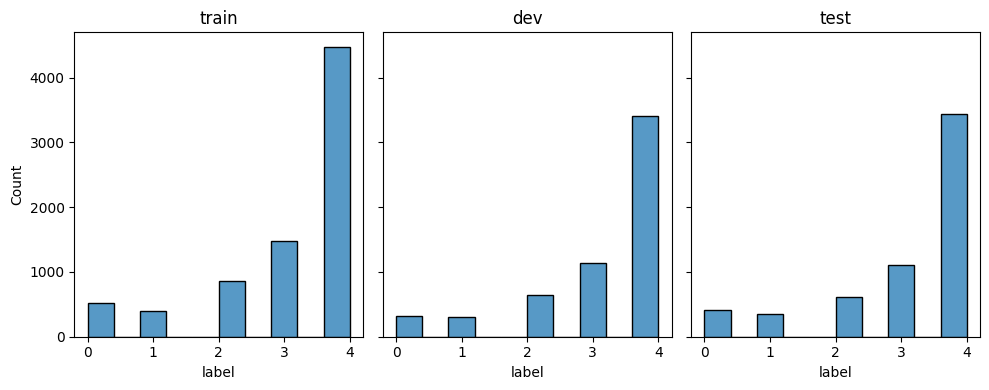

train
           index       bin
0  (-0.001, 0.2]  0.066442
1     (0.2, 0.4]  0.051030
2     (0.4, 0.6]  0.110866
3     (0.6, 0.8]  0.191944
4     (0.8, 1.0]  0.579718
dev
           index       bin
0  (-0.001, 0.2]  0.054533
1     (0.2, 0.4]  0.052985
2     (0.4, 0.6]  0.110614
3     (0.6, 0.8]  0.195768
4     (0.8, 1.0]  0.586100
test
           index       bin
0  (-0.001, 0.2]  0.068297
1     (0.2, 0.4]  0.059022
2     (0.4, 0.6]  0.104553
3     (0.6, 0.8]  0.187858
4     (0.8, 1.0]  0.580270
all
           index       bin
0  (-0.001, 0.2]  0.063450
1     (0.2, 0.4]  0.054048
2     (0.4, 0.6]  0.108868
3     (0.6, 0.8]  0.191841
4     (0.8, 1.0]  0.581792


In [14]:
for src_lang in ("gu", "kk", "zh", "de", "fi", "lt", "ru"):
    language_pair = f"{src_lang}-en"
    print_sep(language_pair)

    output_dir = f"{DIR_DATASET_PREPROC}/{language_pair}/equal-sized-bins"
    os.makedirs(output_dir, exist_ok=True)

    df_darr_w_scores = pd.read_csv(f"{DIR_DATASET_PREPROC}/{language_pair}/{PREPROC_DATA_FILENAME}.csv")
    # -------------------------------------------------------------------------------
    # Step 1. Scale to [0, 1]
    # -------------------------------------------------------------------------------
    df_darr_w_scores["human_score"] = df_darr_w_scores[TARGET_COL].apply(lambda ex: round(ex/100, 4))
    assert df_darr_w_scores["human_score"].apply(lambda ex: 0 <= ex <= 1).all()

    # -------------------------------------------------------------------------------
    # Step 2. Split creation (by src)
    # -------------------------------------------------------------------------------
    src = df_darr_w_scores["src"].unique()
    src_ids = train_test_split_ids(ids=np.arange(len(src)), test_fraction=TEST_FRACTION, dev_fraction=DEV_FRACTION, seed=SEED)
    assert_non_overlapping(src_ids)
    
    dfs = [collect_src(df_darr_w_scores, src, ids) for ids in src_ids]
    dfs_names = ["train", "dev", "test"]
    print("  |  ".join([f"Len({name}): {len(df)}" for name, df in zip(dfs_names, dfs)]))

    # -------------------------------------------------------------------------------
    # Step 3. Plot distributions
    # -------------------------------------------------------------------------------
    print(f"Train, dev, test set `human_score` distribution")
    plot_distributions(data=[d["human_score"] for d in dfs], labels=dfs_names)

    # Step 3.1. Plot *binary* distribution
    print("-" * 70)
    binary_configs = {"binrange": (0, 1), "bins": 2}
    print("2-class distribution using configs:", binary_configs)
    print("-" * 70)

    dfs_class2 = [discretize_dist(d, "human_score", **binary_configs) for d in dfs]
    plot_distributions(data=[d["label"] for d in dfs_class2], labels=dfs_names)

    for d, d_name in zip(dfs_class2, dfs_names):
        if len(d) != 0:
            print(d_name)
            print(get_distribution(d, "bin"))
            d["target"] = d[TARGET_COL].apply(round).apply(int)
            d.to_csv(f"{output_dir}/2class_{d_name}.csv", index=False)

    dfs_class2_all = pd.concat(dfs_class2)
    dfs_class2_all.to_csv(f"{output_dir}/2class_all.csv", index=False)
    print("all")
    print(get_distribution(dfs_class2_all, "bin"))

    # Step 3.2. Plot *5-class* distribution
    print("-" * 80)
    fivary_configs = {"binrange": (0, 1), "bins": 5}
    print("5-Class distribution using configs:", fivary_configs)
    print("-" * 80)
    
    dfs_class5 = [discretize_dist(d, "human_score", **fivary_configs) for d in dfs]
    plot_distributions(data=[d["label"] for d in dfs_class5], labels=dfs_names)

    for d, d_name in zip(dfs_class5, dfs_names):
        if len(d) != 0:
            print(d_name)
            print(get_distribution(d, "bin"))
            d["target"] = d[TARGET_COL].apply(round).apply(int)
            d.to_csv(f"{output_dir}/5class_{d_name}.csv", index=False)


    dfs_class5_all = pd.concat(dfs_class5)
    dfs_class5_all.to_csv(f"{output_dir}/5class_all.csv", index=False)
    print("all")
    print(get_distribution(dfs_class5_all, "bin"))

## Quantile-based bins





gu-en
Len(train): 3644  |  Len(dev): 2736  |  Len(test): 2737
Train, dev, test set `human_score` distribution


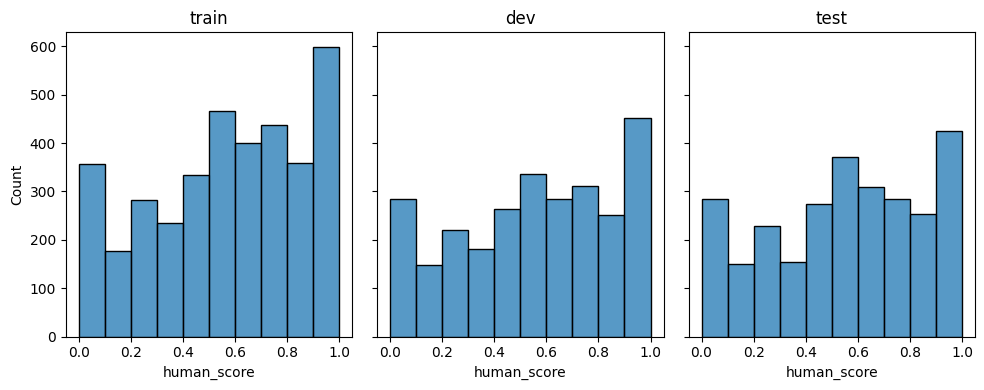

----------------------------------------------------------------------
2-class distribution using configs: {'precision': 2, 'q': 2}
----------------------------------------------------------------------
woho
[0.     0.5956 1.    ]
[-0.01    0.5956  1.    ]


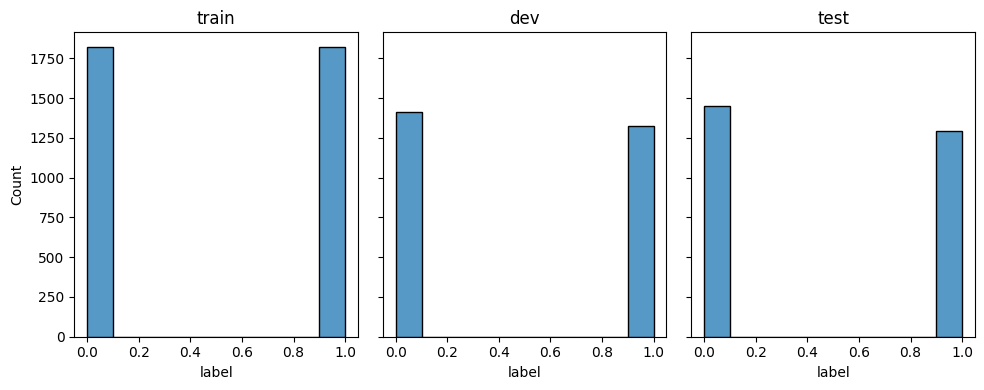

train
          index  bin
0  (-0.01, 0.6]  0.5
1    (0.6, 1.0]  0.5
dev
          index       bin
0  (-0.01, 0.6]  0.516447
1    (0.6, 1.0]  0.483553
test
          index       bin
0  (-0.01, 0.6]  0.528681
1    (0.6, 1.0]  0.471319
all
          index       bin
0  (-0.01, 0.6]  0.513546
1    (0.6, 1.0]  0.486454
--------------------------------------------------------------------------------
5-Class distribution using configs: {'precision': 2, 'q': 5}
--------------------------------------------------------------------------------
woho
[0.   0.26 0.5  0.69 0.86 1.  ]
[-0.01  0.26  0.5   0.69  0.86  1.  ]


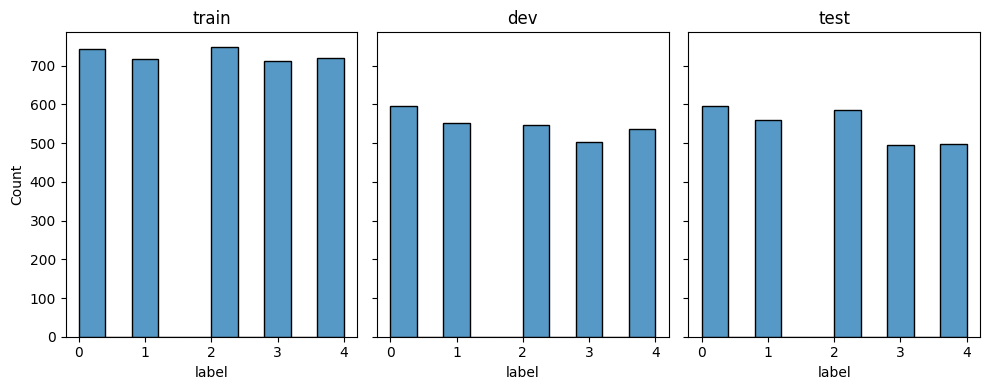

train
           index       bin
0  (-0.01, 0.26]  0.204171
1    (0.26, 0.5]  0.196762
2    (0.5, 0.69]  0.205543
3   (0.69, 0.86]  0.195664
4    (0.86, 1.0]  0.197859
dev
           index       bin
0  (-0.01, 0.26]  0.218202
1    (0.26, 0.5]  0.202120
2    (0.5, 0.69]  0.199561
3   (0.69, 0.86]  0.184211
4    (0.86, 1.0]  0.195906
test
           index       bin
0  (-0.01, 0.26]  0.217757
1    (0.26, 0.5]  0.204969
2    (0.5, 0.69]  0.213738
3   (0.69, 0.86]  0.181220
4    (0.86, 1.0]  0.182316
all
           index       bin
0  (-0.01, 0.26]  0.212460
1    (0.26, 0.5]  0.200834
2    (0.5, 0.69]  0.206208
3   (0.69, 0.86]  0.187891
4    (0.86, 1.0]  0.192607




kk-en
Len(train): 2554  |  Len(dev): 1928  |  Len(test): 1940
Train, dev, test set `human_score` distribution


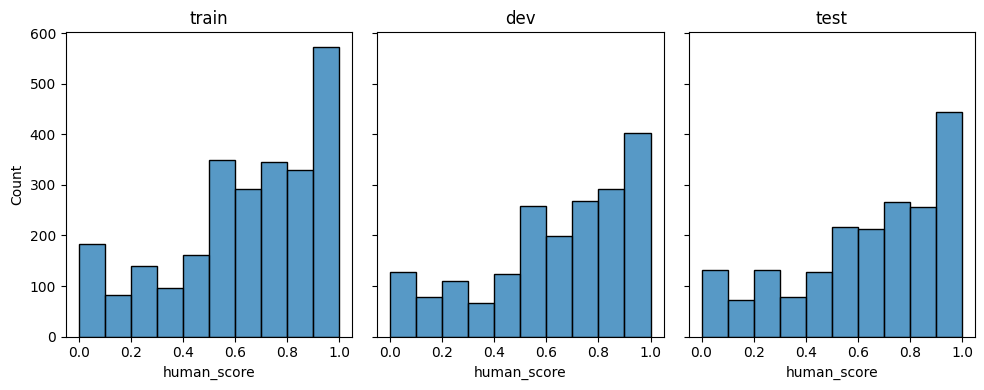

----------------------------------------------------------------------
2-class distribution using configs: {'precision': 2, 'q': 2}
----------------------------------------------------------------------
woho
[0.    0.695 1.   ]
[-0.01   0.695  1.   ]


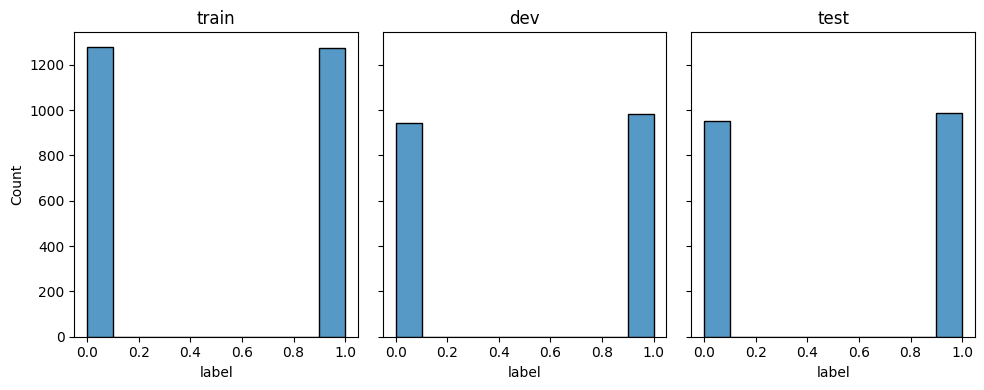

train
          index       bin
0  (-0.01, 0.7]  0.500783
1    (0.7, 1.0]  0.499217
dev
          index       bin
0  (-0.01, 0.7]  0.489627
1    (0.7, 1.0]  0.510373
test
          index       bin
0  (-0.01, 0.7]  0.491237
1    (0.7, 1.0]  0.508763
all
          index      bin
0  (-0.01, 0.7]  0.49455
1    (0.7, 1.0]  0.50545
--------------------------------------------------------------------------------
5-Class distribution using configs: {'precision': 2, 'q': 5}
--------------------------------------------------------------------------------
woho
[0.      0.4     0.61    0.76    0.91466 1.     ]
[-0.01     0.4      0.61     0.76     0.91466  1.     ]


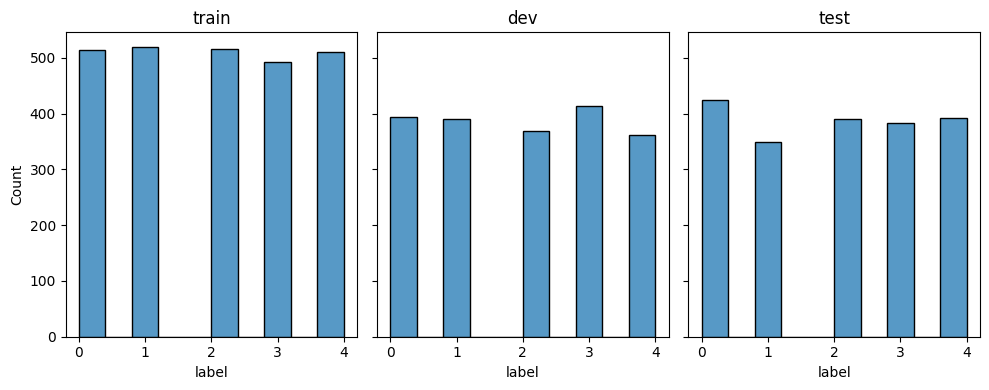

train
          index       bin
0  (-0.01, 0.4]  0.201644
1   (0.4, 0.61]  0.203602
2  (0.61, 0.76]  0.202036
3  (0.76, 0.91]  0.192639
4   (0.91, 1.0]  0.200078
dev
          index       bin
0  (-0.01, 0.4]  0.204357
1   (0.4, 0.61]  0.202282
2  (0.61, 0.76]  0.191390
3  (0.76, 0.91]  0.214730
4   (0.91, 1.0]  0.187241
test
          index       bin
0  (-0.01, 0.4]  0.219072
1   (0.4, 0.61]  0.179897
2  (0.61, 0.76]  0.201031
3  (0.76, 0.91]  0.197423
4   (0.91, 1.0]  0.202577
all
          index       bin
0  (-0.01, 0.4]  0.207723
1   (0.4, 0.61]  0.196045
2  (0.61, 0.76]  0.198536
3  (0.76, 0.91]  0.200716
4   (0.91, 1.0]  0.196979




zh-en
Len(train): 6972  |  Len(dev): 5184  |  Len(test): 5122
Train, dev, test set `human_score` distribution


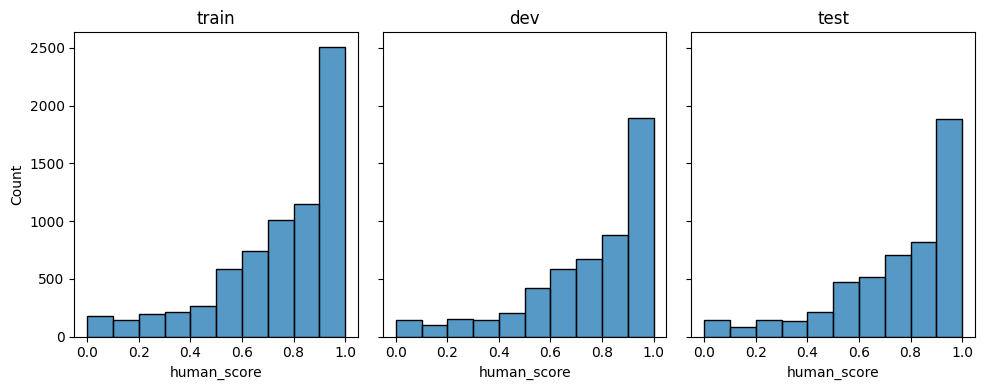

----------------------------------------------------------------------
2-class distribution using configs: {'precision': 2, 'q': 2}
----------------------------------------------------------------------
woho
[0.   0.81 1.  ]
[-0.01  0.81  1.  ]


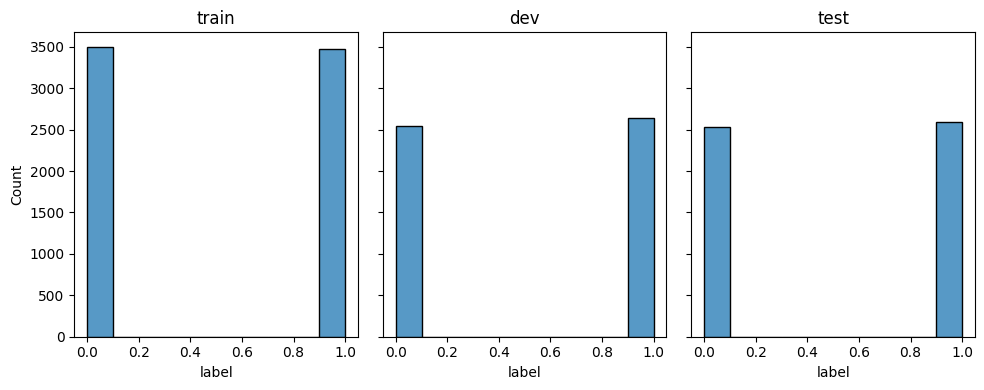

train
           index       bin
0  (-0.01, 0.81]  0.501865
1    (0.81, 1.0]  0.498135
dev
           index       bin
0  (-0.01, 0.81]  0.489776
1    (0.81, 1.0]  0.510224
test
           index       bin
0  (-0.01, 0.81]  0.493167
1    (0.81, 1.0]  0.506833
all
           index       bin
0  (-0.01, 0.81]  0.495659
1    (0.81, 1.0]  0.504341
--------------------------------------------------------------------------------
5-Class distribution using configs: {'precision': 2, 'q': 5}
--------------------------------------------------------------------------------
woho
[0.   0.57 0.75 0.88 0.96 1.  ]
[-0.01  0.57  0.75  0.88  0.96  1.  ]


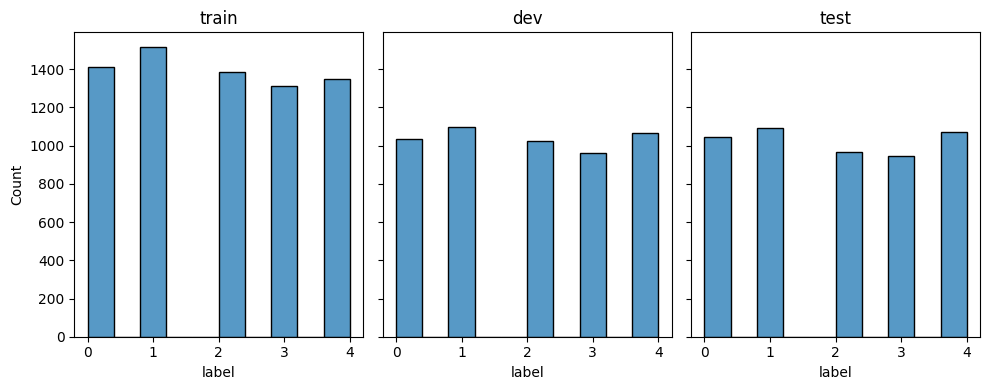

train
           index       bin
0  (-0.01, 0.57]  0.202668
1   (0.57, 0.75]  0.217585
2   (0.75, 0.88]  0.198508
3   (0.88, 0.96]  0.188038
4    (0.96, 1.0]  0.193201
dev
           index       bin
0  (-0.01, 0.57]  0.200039
1   (0.57, 0.75]  0.211227
2   (0.75, 0.88]  0.197531
3   (0.88, 0.96]  0.185571
4    (0.96, 1.0]  0.205633
test
           index       bin
0  (-0.01, 0.57]  0.204217
1   (0.57, 0.75]  0.213198
2   (0.75, 0.88]  0.188793
3   (0.88, 0.96]  0.185084
4    (0.96, 1.0]  0.208708
all
           index       bin
0  (-0.01, 0.57]  0.202338
1   (0.57, 0.75]  0.214377
2   (0.75, 0.88]  0.195335
3   (0.88, 0.96]  0.186422
4    (0.96, 1.0]  0.201528




de-en
Len(train): 12062  |  Len(dev): 9077  |  Len(test): 9011
Train, dev, test set `human_score` distribution


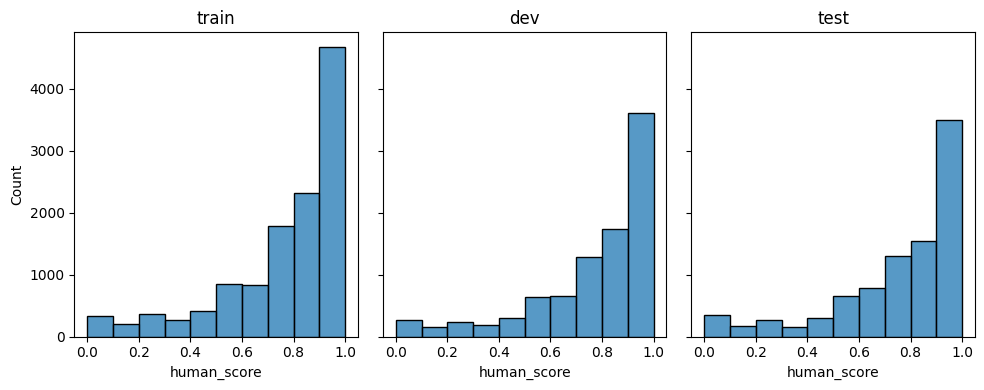

----------------------------------------------------------------------
2-class distribution using configs: {'precision': 2, 'q': 2}
----------------------------------------------------------------------
woho
[0.   0.85 1.  ]
[-0.01  0.85  1.  ]


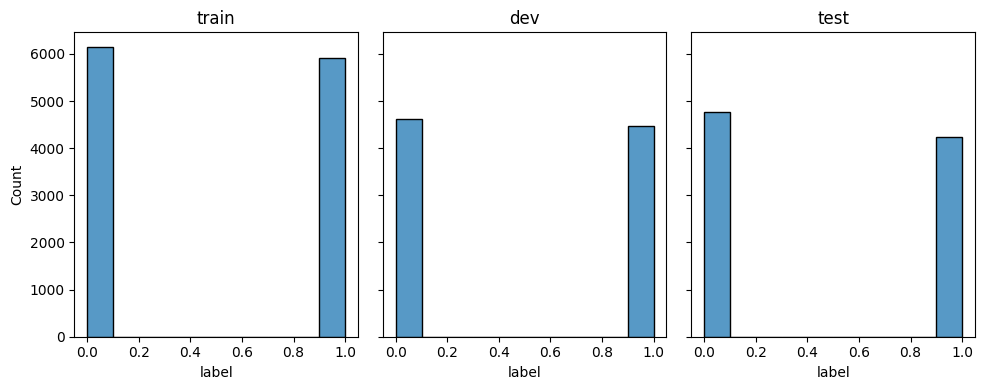

train
           index       bin
0  (-0.01, 0.85]  0.509949
1    (0.85, 1.0]  0.490051
dev
           index       bin
0  (-0.01, 0.85]  0.507987
1    (0.85, 1.0]  0.492013
test
           index       bin
0  (-0.01, 0.85]  0.530241
1    (0.85, 1.0]  0.469759
all
           index       bin
0  (-0.01, 0.85]  0.515423
1    (0.85, 1.0]  0.484577
--------------------------------------------------------------------------------
5-Class distribution using configs: {'precision': 2, 'q': 5}
--------------------------------------------------------------------------------
woho
[0.   0.6  0.78 0.89 0.97 1.  ]
[-0.01  0.6   0.78  0.89  0.97  1.  ]


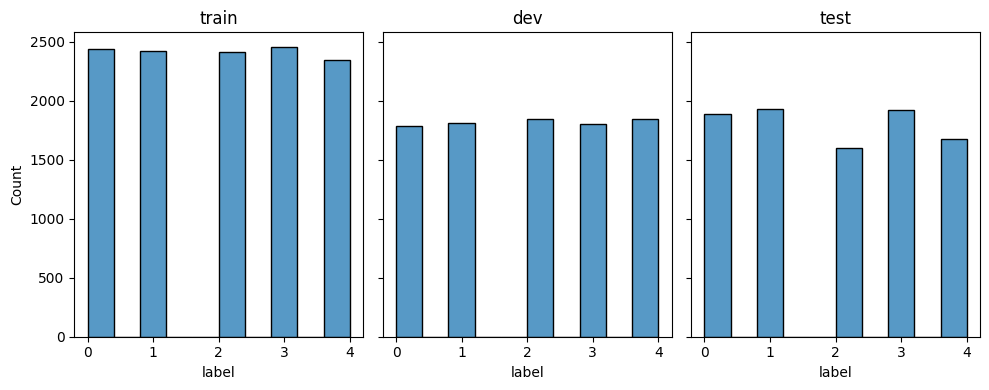

train
          index       bin
0  (-0.01, 0.6]  0.202039
1   (0.6, 0.78]  0.200381
2  (0.78, 0.89]  0.199884
3  (0.89, 0.97]  0.203615
4   (0.97, 1.0]  0.194081
dev
          index       bin
0  (-0.01, 0.6]  0.196431
1   (0.6, 0.78]  0.199295
2  (0.78, 0.89]  0.203041
3  (0.89, 0.97]  0.198193
4   (0.97, 1.0]  0.203041
test
          index       bin
0  (-0.01, 0.6]  0.209855
1   (0.6, 0.78]  0.214183
2  (0.78, 0.89]  0.177561
3  (0.89, 0.97]  0.212740
4   (0.97, 1.0]  0.185662
all
          index       bin
0  (-0.01, 0.6]  0.202687
1   (0.6, 0.78]  0.204179
2  (0.78, 0.89]  0.194163
3  (0.89, 0.97]  0.204710
4   (0.97, 1.0]  0.194262




fi-en
Len(train): 6638  |  Len(dev): 5013  |  Len(test): 4926
Train, dev, test set `human_score` distribution


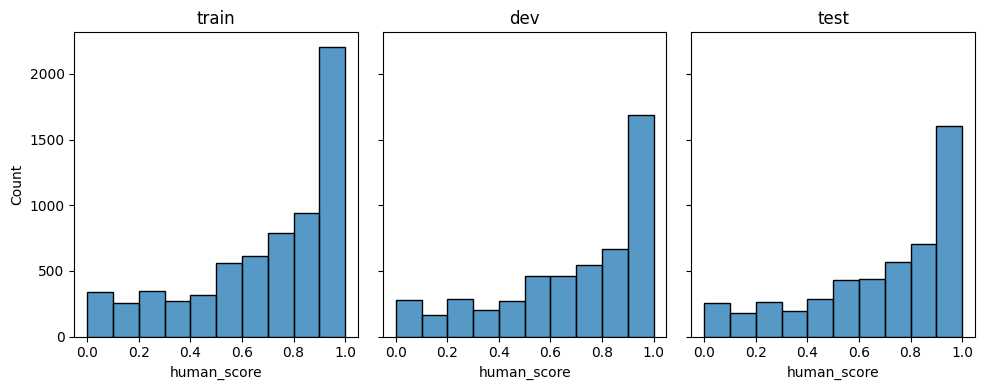

----------------------------------------------------------------------
2-class distribution using configs: {'precision': 2, 'q': 2}
----------------------------------------------------------------------
woho
[0.   0.77 1.  ]
[-0.01  0.77  1.  ]


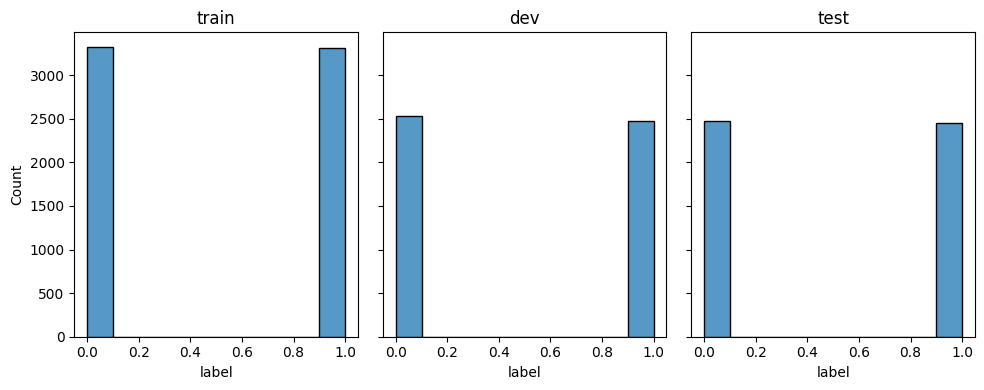

train
           index       bin
0  (-0.01, 0.77]  0.500753
1    (0.77, 1.0]  0.499247
dev
           index       bin
0  (-0.01, 0.77]  0.505885
1    (0.77, 1.0]  0.494115
test
           index       bin
0  (-0.01, 0.77]  0.502233
1    (0.77, 1.0]  0.497767
all
           index       bin
0  (-0.01, 0.77]  0.502745
1    (0.77, 1.0]  0.497255
--------------------------------------------------------------------------------
5-Class distribution using configs: {'precision': 2, 'q': 5}
--------------------------------------------------------------------------------
woho
[0.   0.44 0.7  0.85 0.97 1.  ]
[-0.01  0.44  0.7   0.85  0.97  1.  ]


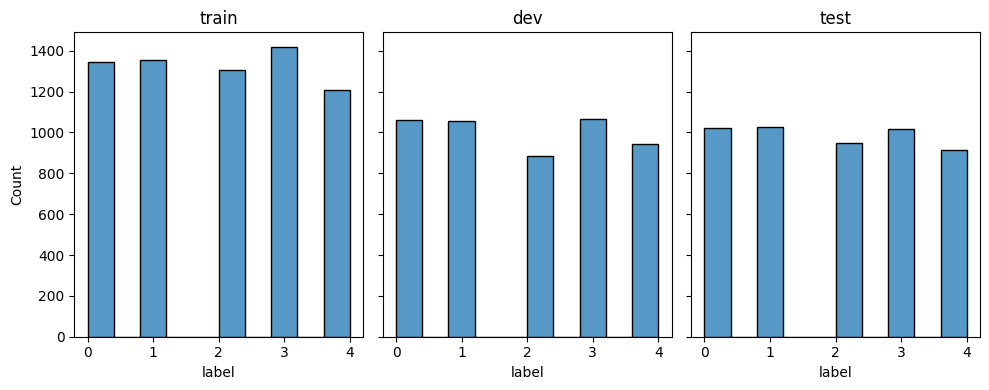

train
           index       bin
0  (-0.01, 0.44]  0.202772
1    (0.44, 0.7]  0.204128
2    (0.7, 0.85]  0.197047
3   (0.85, 0.97]  0.213769
4    (0.97, 1.0]  0.182284
dev
           index       bin
0  (-0.01, 0.44]  0.211251
1    (0.44, 0.7]  0.211051
2    (0.7, 0.85]  0.176940
3   (0.85, 0.97]  0.212847
4    (0.97, 1.0]  0.187911
test
           index       bin
0  (-0.01, 0.44]  0.207674
1    (0.44, 0.7]  0.208080
2    (0.7, 0.85]  0.192042
3   (0.85, 0.97]  0.206456
4    (0.97, 1.0]  0.185749
all
           index       bin
0  (-0.01, 0.44]  0.206793
1    (0.44, 0.7]  0.207396
2    (0.7, 0.85]  0.189479
3   (0.85, 0.97]  0.211317
4    (0.97, 1.0]  0.185015




lt-en
Len(train): 4153  |  Len(dev): 3085  |  Len(test): 3055
Train, dev, test set `human_score` distribution


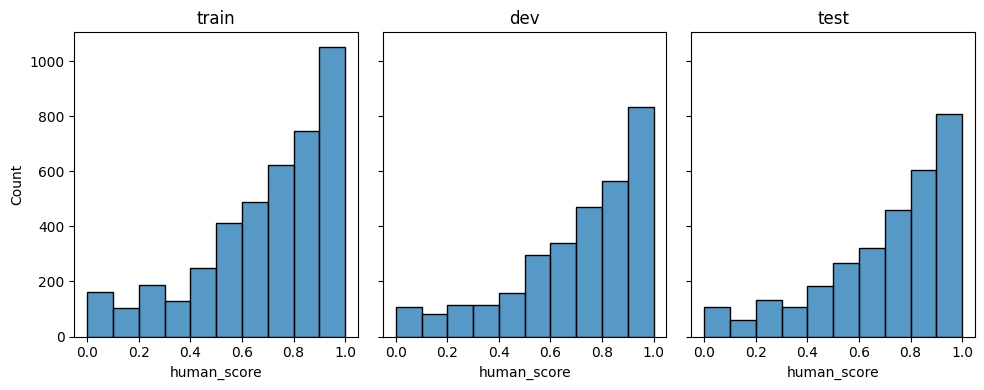

----------------------------------------------------------------------
2-class distribution using configs: {'precision': 2, 'q': 2}
----------------------------------------------------------------------
woho
[0.     0.7567 1.    ]
[-0.01    0.7567  1.    ]


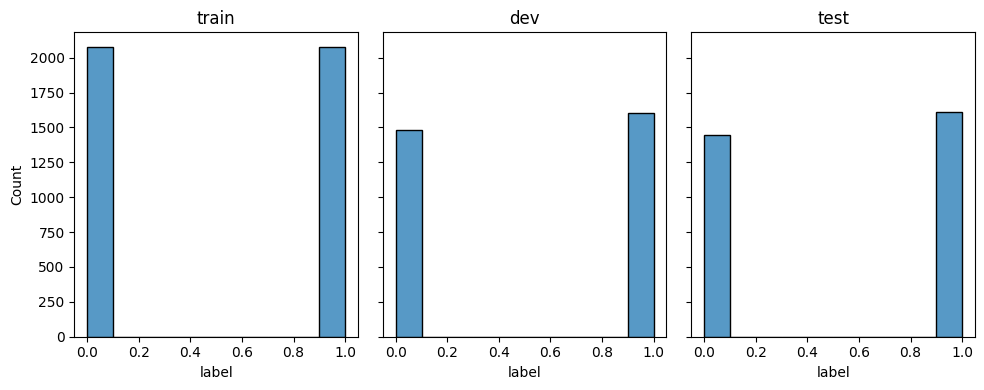

train
           index       bin
0  (-0.01, 0.76]  0.500361
1    (0.76, 1.0]  0.499639
dev
           index       bin
0  (-0.01, 0.76]  0.480389
1    (0.76, 1.0]  0.519611
test
           index      bin
0  (-0.01, 0.76]  0.47234
1    (0.76, 1.0]  0.52766
all
           index       bin
0  (-0.01, 0.76]  0.486058
1    (0.76, 1.0]  0.513942
--------------------------------------------------------------------------------
5-Class distribution using configs: {'precision': 2, 'q': 5}
--------------------------------------------------------------------------------
woho
[0.      0.49802 0.687   0.82    0.92    1.     ]
[-0.01     0.49802  0.687    0.82     0.92     1.     ]


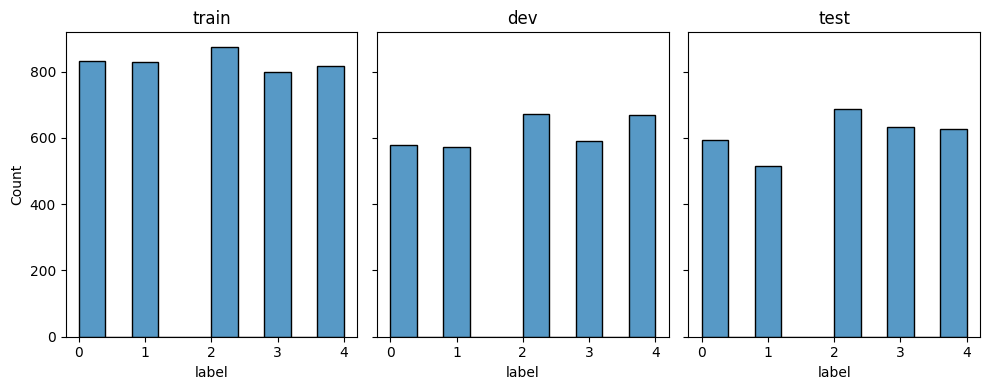

train
          index       bin
0  (-0.01, 0.5]  0.200096
1   (0.5, 0.69]  0.199856
2  (0.69, 0.82]  0.210691
3  (0.82, 0.92]  0.192391
4   (0.92, 1.0]  0.196966
dev
          index       bin
0  (-0.01, 0.5]  0.188006
1   (0.5, 0.69]  0.185737
2  (0.69, 0.82]  0.217828
3  (0.82, 0.92]  0.191572
4   (0.92, 1.0]  0.216856
test
          index       bin
0  (-0.01, 0.5]  0.194763
1   (0.5, 0.69]  0.168249
2  (0.69, 0.82]  0.224877
3  (0.82, 0.92]  0.207201
4   (0.92, 1.0]  0.204910
all
          index       bin
0  (-0.01, 0.5]  0.194890
1   (0.5, 0.69]  0.186243
2  (0.69, 0.82]  0.217041
3  (0.82, 0.92]  0.196541
4   (0.92, 1.0]  0.205285




ru-en
Len(train): 7721  |  Len(dev): 5813  |  Len(test): 5930
Train, dev, test set `human_score` distribution


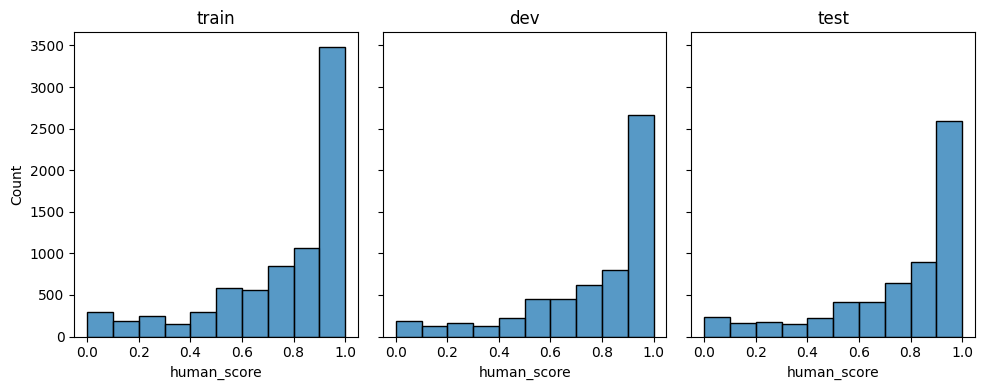

----------------------------------------------------------------------
2-class distribution using configs: {'precision': 2, 'q': 2}
----------------------------------------------------------------------
woho
[0.   0.86 1.  ]
[-0.01  0.86  1.  ]


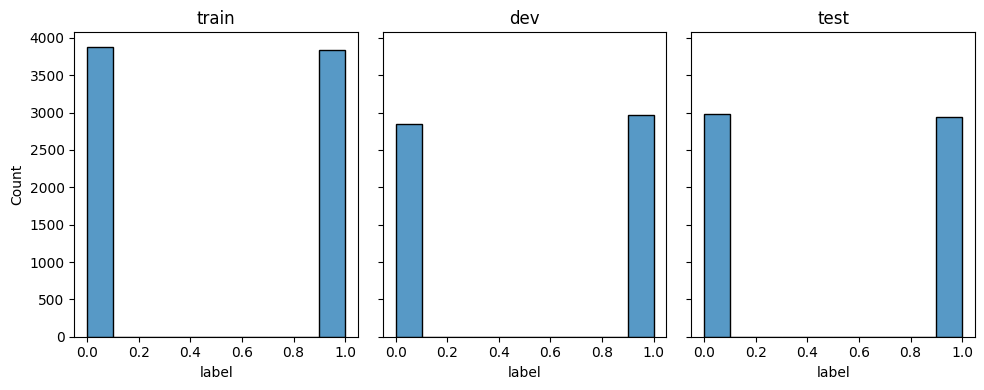

train
           index       bin
0  (-0.01, 0.86]  0.502526
1    (0.86, 1.0]  0.497474
dev
           index       bin
0  (-0.01, 0.86]  0.489936
1    (0.86, 1.0]  0.510064
test
           index       bin
0  (-0.01, 0.86]  0.503373
1    (0.86, 1.0]  0.496627
all
           index       bin
0  (-0.01, 0.86]  0.499024
1    (0.86, 1.0]  0.500976
--------------------------------------------------------------------------------
5-Class distribution using configs: {'precision': 2, 'q': 5}
--------------------------------------------------------------------------------
woho
[0.   0.56 0.79 0.92 0.98 1.  ]
[-0.01  0.56  0.79  0.92  0.98  1.  ]


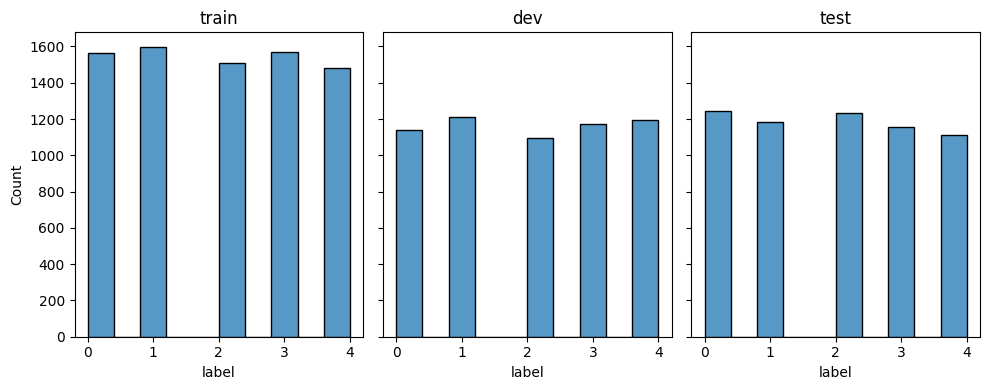

train
           index       bin
0  (-0.01, 0.56]  0.202564
1   (0.56, 0.79]  0.206968
2   (0.79, 0.92]  0.195182
3   (0.92, 0.98]  0.203342
4    (0.98, 1.0]  0.191944
dev
           index       bin
0  (-0.01, 0.56]  0.195596
1   (0.56, 0.79]  0.207982
2   (0.79, 0.92]  0.188715
3   (0.92, 0.98]  0.201789
4    (0.98, 1.0]  0.205918
test
           index       bin
0  (-0.01, 0.56]  0.210287
1   (0.56, 0.79]  0.199494
2   (0.79, 0.92]  0.208094
3   (0.92, 0.98]  0.194941
4    (0.98, 1.0]  0.187184
all
           index       bin
0  (-0.01, 0.56]  0.202836
1   (0.56, 0.79]  0.204994
2   (0.79, 0.92]  0.197185
3   (0.92, 0.98]  0.200319
4    (0.98, 1.0]  0.194667


In [20]:
for src_lang in ("gu", "kk", "zh", "de", "fi", "lt", "ru"):
    language_pair = f"{src_lang}-en"
    print_sep(language_pair)

    output_dir = f"{DIR_DATASET_PREPROC}/{language_pair}/quantile"
    os.makedirs(output_dir, exist_ok=True)

    df_darr_w_scores = pd.read_csv(f"{DIR_DATASET_PREPROC}/{language_pair}/{PREPROC_DATA_FILENAME}.csv")
    # -------------------------------------------------------------------------------
    # Step 1. Scale to [0, 1]
    # -------------------------------------------------------------------------------
    df_darr_w_scores["human_score"] = df_darr_w_scores[TARGET_COL].apply(lambda ex: round(ex/100, 4))
    assert df_darr_w_scores["human_score"].apply(lambda ex: 0 <= ex <= 1).all()

    # -------------------------------------------------------------------------------
    # Step 2. Split creation (by src)
    # -------------------------------------------------------------------------------
    src = df_darr_w_scores["src"].unique()
    src_ids = train_test_split_ids(ids=np.arange(len(src)), test_fraction=TEST_FRACTION, dev_fraction=DEV_FRACTION, seed=SEED)
    assert_non_overlapping(src_ids)
    
    dfs = [collect_src(df_darr_w_scores, src, ids) for ids in src_ids]
    dfs_names = ["train", "dev", "test"]
    print("  |  ".join([f"Len({name}): {len(df)}" for name, df in zip(dfs_names, dfs)]))

    # -------------------------------------------------------------------------------
    # Step 3. Plot distributions
    # -------------------------------------------------------------------------------
    print(f"Train, dev, test set `human_score` distribution")
    plot_distributions(data=[d["human_score"] for d in dfs], labels=dfs_names)

    # Step 3.1. Plot *binary* distribution
    print("-" * 70)
    binary_configs = {"precision": 2, "q": 2}
    print("2-class distribution using configs:", binary_configs)
    print("-" * 70)

    dfs_class2 = get_quantile_dists(dfs, "human_score", **binary_configs)
    plot_distributions(data=[d["label"] for d in dfs_class2], labels=dfs_names)

    for d, d_name in zip(dfs_class2, dfs_names):
        if len(d) != 0:
            print(d_name)
            print(get_distribution(d, "bin"))
            d["target"] = d[TARGET_COL].apply(round).apply(int)
            d.to_csv(f"{output_dir}/2class_{d_name}.csv", index=False)

    dfs_class2_all = pd.concat(dfs_class2)
    dfs_class2_all.to_csv(f"{output_dir}/2class_all.csv", index=False)
    print("all")
    print(get_distribution(dfs_class2_all, "bin"))

    # Step 3.2. Plot *5-class* distribution
    print("-" * 80)
    fivary_configs = {"precision": 2, "q": 5}
    print("5-Class distribution using configs:", fivary_configs)
    print("-" * 80)
    
    dfs_class5 = get_quantile_dists(dfs, "human_score", **fivary_configs)
    plot_distributions(data=[d["label"] for d in dfs_class5], labels=dfs_names)

    for d, d_name in zip(dfs_class5, dfs_names):
        if len(d) != 0:
            print(d_name)
            print(get_distribution(d, "bin"))
            d["target"] = d[TARGET_COL].apply(round).apply(int)
            d.to_csv(f"{output_dir}/5class_{d_name}.csv", index=False)


    dfs_class5_all = pd.concat(dfs_class5)
    dfs_class5_all.to_csv(f"{output_dir}/5class_all.csv", index=False)
    print("all")
    print(get_distribution(dfs_class5_all, "bin"))

In [22]:
d["target"]

0        91
1         6
2        96
3        67
4        98
       ... 
5925     94
5926     91
5927    100
5928     91
5929     85
Name: target, Length: 5930, dtype: int64